## Rapid Reinforcement Learning

author: Cesare Carissimo

The goal of this notebook is to walk through the ambitions of Rapid Reinforcement Learning, discussing the ideas and giving examples with experiments. The main ambitions of Rapid RL are two:

> Learn an optimal policy for the Willemsen Gridworld in three trajectories. 

> Efficiently find sparse rewards in arbitraty environments.

What is the Willemsen Gridworld?

#### Willemsen Gridworld

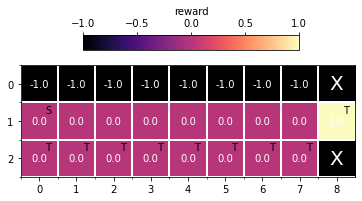

In [2]:
import numpy as np

grid = np.ones((3, 9)) * -1
grid[1,:8] = 0
grid[1, 8] = 1
grid[2, :8] = 0
terminal_state = []
for i in [0,2]:
    for j in range(8):
        terminal_state.append([i,j])
terminal_state.append([1,8])
terminal_state = np.array(terminal_state)
initial_state = np.array([1, 0])
blacked_state = np.array([[0, 8],[2, 8]])

from MDP import *

_, _, _, _ = plot_gridworld(grid, terminal_state, initial_state, blacked_state)

The Willemsen Gridworld (WG) features a 3 x 9 grid, and is successfully completed by reaching the far right cell at (1, 8). The optimal policy for WG is to exclusively go RIGHT from the initial position at (1, 0). 

To learn this optimal policy we would will try different action selection methods. We define an action selection method as one that achieves both our ambitions: it finds an optimal policy in 3 trajectories in the WG, and it efficiently explores other environments with sparse rewards.

### Simple Q-Learning

Lets start our investigation by taking a look at the performance of a simple q-learner on WG. The exploration strategy for our simple Q learner will be epsilon greedy.

In [12]:
# PARAMETERS TO SET FOR EXPERIMENT
max_steps = 1000
episode_timeout = 40
gamma = 0.8
alpha = 0.1

EXPLORATION_TYPE = 'LambQ_simple_extrinsic'
batch_size = 1
FILE_SIG = f"Results_n={max_steps}, nB={batch_size}, exp={EXPLORATION_TYPE} WG, N_init_1"

env = Gridworld(grid, terminal_state, initial_state, blacked_state, episode_timeout)
env_greedy = Gridworld(grid, terminal_state, initial_state, blacked_state, episode_timeout)

In [20]:
agent = eGreedy(estimators = [Estimator(approximator=bellman_Q_table(alpha=0.1, gamma=0.8), mask=identity()),
                             Estimator(approximator=global_Q_abstractor(gamma=0.8),  mask=global_context())],
                    buffer = ReplayMemory(max_size=10000),
                    targets = [Target()],
                    counter = state_table(),
                    batch_size=batch_size)

agent.epsilon = 0.33

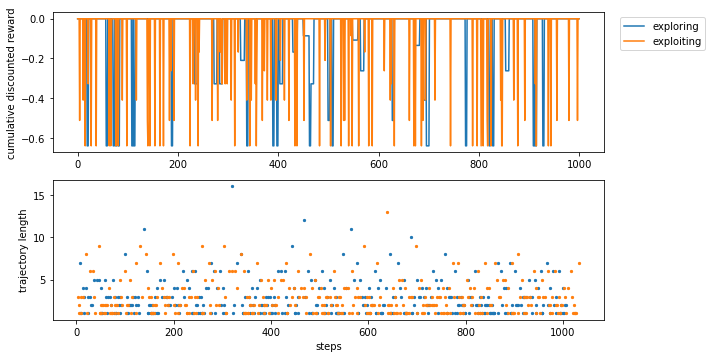

In [23]:
# MAIN TRAINING and EVALUATION LOOP

trajectories = []
metrics = []
epilen = []
Gn = []
step = 0
while step < max_steps:
    # EXPLORE: by setting action selection to be explorative: "exploratory"
    agent.action_selection = "exploratory"
    action = agent.select_action(env.transition)
    transition = env.step(action)
    agent.observe(transition)
    Gn.append(transition.reward)
    agent.train()

    # EXPLOIT: by setting action selection to be exploitative: "greedy"
    agent.action_selection = "greedy"
    agent.epsilon = 0
    Gg = []

    # RUN entire trajectory, and set greedy env to the initial state
    env_greedy.reset()
    while not env_greedy.terminal and not env_greedy.timeout:
        action = agent.select_action(env_greedy.transition)
        transition = env_greedy.step(action)
        Gg.append(transition.reward)

    step += 1

    metrics.append({
        'Qsa': dict(agent.estimators[0].approximator.table),
        'Qa': dict(agent.estimators[1].evaluate(0)),
        'S': transition.state_,
        'V': dict(agent.counter.table),
        'U': dict(agent.estimators[0].visits),
        'Gn': Gn,
        'Gg': Gg,
        'steps': step
        })

    if env.terminal or env.timeout:
        trajectories.append(agent.trajectory)
        epilen.append([len(agent.trajectory), len(Gg)])

        env.reset()
        agent.reset_trajectory()
        Gn = []
        
x = np.arange(0, metrics[-1]['steps'])
yn = []
yg = []
for i, metric in enumerate(metrics):
    Yn = 0
    Yg = 0
    for j, g in enumerate(metric['Gn']):
        Yn += gamma**j*g
    for j, g in enumerate(metric['Gg']):
        Yg += gamma**j*g
    
    yn.append(Yn)
    yg.append(Yg)

cumEpilen = np.cumsum([ele[0] for ele in epilen])
cumEpiG = np.cumsum([ele[1] for ele in epilen])

%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,5))
ax1.plot(x, yn, label='exploring')

ax1.plot(x, yg, label='exploiting')

ax1.set_ylabel('cumulative discounted reward')
plt.xlabel('steps')

ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

ax2.set_ylabel('trajectory length')
ax2.scatter(cumEpilen, [ele[0] for ele in epilen], s=5)
ax2.scatter(cumEpiG, [ele[1] for ele in epilen], s=5)
plt.tight_layout()

In [26]:
from matplotlib import animation, rc

dict_max = lambda x: max(v for v in x.values())
dict_mean = lambda x: sum(v for v in x.values())/len(x)
dict_min = lambda x: min(v for v in x.values())
dict_sum = lambda x: sum(v for v in x.values())

def generate_heatmap(grid, table, aggf=None, actions=False):
    if actions:
        hm = np.zeros((3,3))
        if aggf is None:
            aggf = lambda x: x

        hm[0,1] = table['up']
        hm[1,2] = table['right']
        hm[1,0] = table['left']
        hm[2,1] = table['down']

    else:
        hm = np.copy(grid) * 0
        if aggf is None:
            aggf = lambda x: x

        for k, v in table.items():
            hm[k] = aggf(v)

    return hm

def animate_values(data, fn=None):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(grid.shape[1], grid.shape[0]))

    for col in axs:
        col.set_axis_off()

    ims = []
    for i in range(len(data)):
        
        imQsa = axs[0].imshow(generate_heatmap(grid=grid, table=data[i]['Qsa'], aggf=fn), animated=True, origin='upper')
        imQa = axs[1].imshow(generate_heatmap(grid=grid, table=data[i]['Qa'], actions=True), animated=True, origin='upper')
        agent_marker = axs[0].text(data[i]['S'][1], data[i]['S'][0], 'X', ha="center", va="center", color="black", fontsize=20)
        ims.append([imQsa, imQa])
        agent_marker.remove()
        
    fig.colorbar(imQsa, ax=axs.ravel().tolist())
    
    ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True, repeat_delay=1000)
    plt.close()

    return ani

In [27]:
from IPython.display import HTML
ani = animate_values(metrics, fn=dict_max)
estimator = ['Qsa', 'Qa']
HTML(ani.to_html5_video())
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=3, metadata=dict(artist='Cesare Carissimo'), bitrate=1800)
# ani.save(f"{FILE_SIG}-%s.mp4" % estimator, writer=writer)

RuntimeError: Requested MovieWriter (ffmpeg) not available